In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'creditcardfraud:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240603%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240603T084257Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D480afaf416044964cdd1c017000fc1052146d0b15922cff2f4e484eb0750f40786d05c3f7b330deac0c26487b90b4b63a1e08f2ab95a8037d41f05595305b6364f52bfcd83e8286205d778c71f8cf48ce771626ae68713cf6d28c4175f36b150342b241f2dc3c36b00dc001956f544c53911e37cac11ac43d0b23eaad0586c5fe7cb893b49d874c24f6744163ec28bc0777c41ca92421eeddb29a5af2ea2cfe67765387d19f1137719471f84cd7f3289ed820a485770bd25ef212cd45a17769f8088fe0b8386fd629422356bf97eb8ae16a19eb8e647722303fb880824967d5d1ddb76450df31ecf678fac630431035321bdab01d2d35a1c5591f1320bcbc2d9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69155672 bytes downloaded
Downloaded and uncompressed: creditcardfraud
Data source import complete.


# Credit Card Fraud Detection

This notebook demonstrates the process of detecting credit card fraud using various machine learning models, including Random Forest, AdaBoost, CatBoost, XGBoost, LightGBM, and Logistic Regression. We also perform hyperparameter tuning to select the best model.

## Table of Contents
1. [Load Packages and Data](#load-packages-and-data)
2. [Exploratory Data Analysis](#eda)
3. [Data Preprocessing](#data-preprocessing)
4. [Model Training and Hyperparameter Tuning](#model-training-and-hyperparameter-tuning)
5. [Model Evaluation](#model-evaluation)
6. [Conclusion](#conclusion)


## Load Packages and Data <a id="load-packages-and-data"></a>


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import xgboost as xgb
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


<h5>Importing data<h5>

In [5]:
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

## Exploratory data analysis Load Packages and Data <a id="eda"></a>

In [6]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

no missing values

In [8]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Class
0    284315
1       492
Name: count, dtype: int64


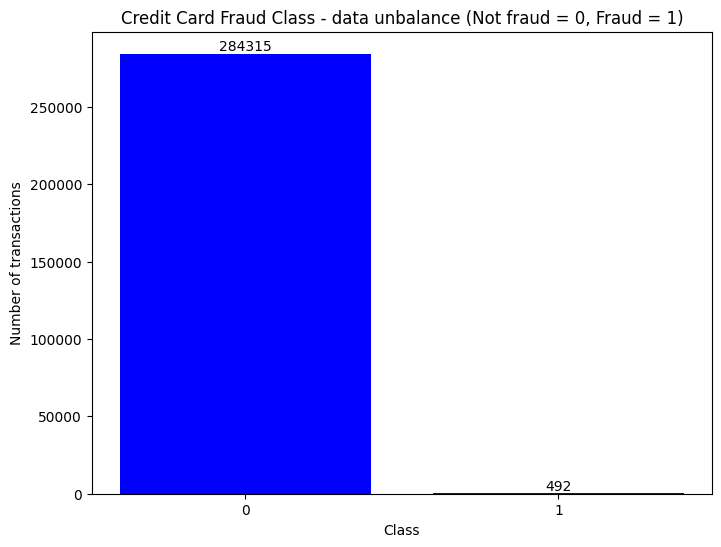

In [9]:
class_count = data["Class"].value_counts()
print(class_count)
class_count_df = pd.DataFrame({'Class': class_count.index, 'values': class_count.values})

plt.figure(figsize=(8, 6))
plt.bar(class_count_df['Class'], class_count_df['values'], color='blue')
plt.title('Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)')
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.xticks(class_count_df['Class'])
for i in range(len(class_count_df)):
    plt.text(class_count_df['Class'][i], class_count_df['values'][i], class_count_df['values'][i], ha='center', va='bottom')
plt.show()


We can see that the data is highly imbalanced with 28315 for class 0 and 492 for class 1

Let's split the data to fraud and not_fraud:

In [10]:
not_fraud = data.loc[data['Class'] == 0]
fraud = data.loc[data['Class'] == 1]

In [11]:
not_fraud.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [12]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

We can see there is a remarkable difference between the mean of the amount of fraud and not_fraud

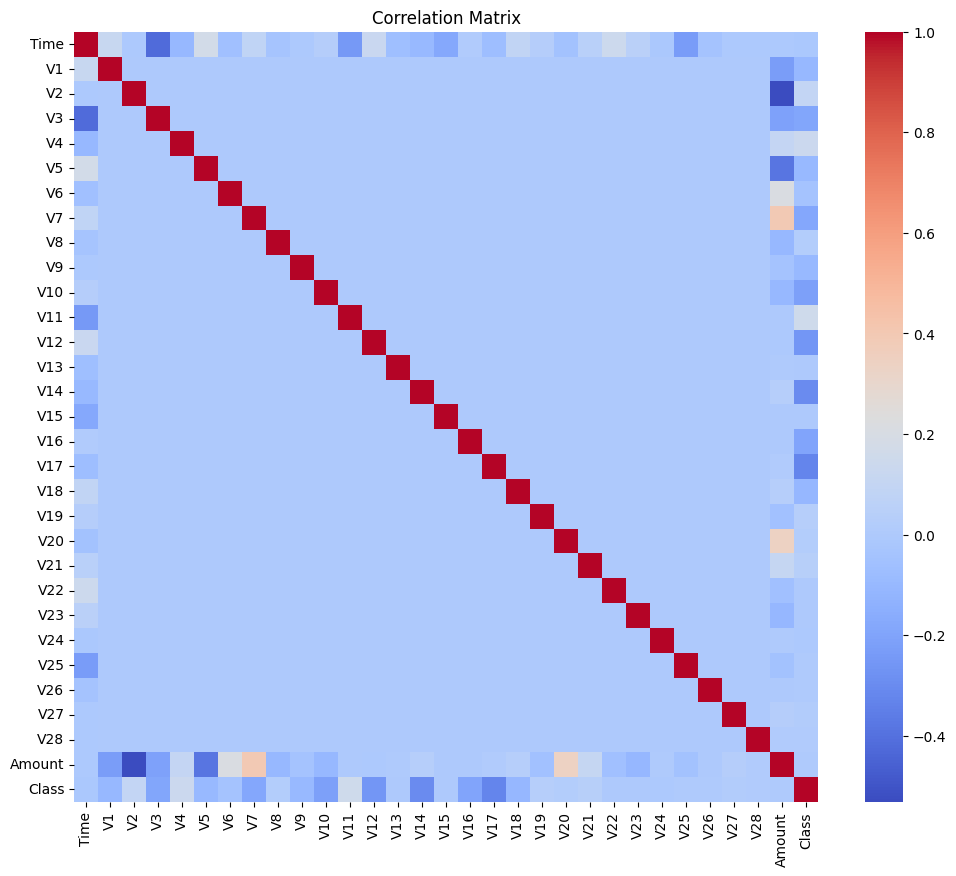

In [13]:
# Compute the correlation matrix
corr_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()


## Data Preprocessing <a id="data-preprocessing"></a>

<h4>Approach to solve unbalanced data</h4>
Creating new sample dataset containing same distribution as normal transactions and fraudulent transactions

In [14]:
not_fraud_sample = not_fraud.sample(n=492)

In [15]:
new_dataset = pd.concat([not_fraud_sample, fraud], axis=0)

In [16]:
new_dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
274952,166293.0,-1.331259,0.643609,0.163298,-0.060846,-0.237415,0.544533,-0.775235,1.120992,-0.171801,...,0.380121,1.047990,-0.213169,0.325679,-0.604388,0.695322,0.130194,-0.004947,40.94,0
161795,114527.0,1.804493,-0.141670,-1.652570,0.728530,-0.163646,-1.725874,0.437472,-0.453918,0.547208,...,0.293393,0.758965,-0.070195,0.402227,0.154913,-0.141959,-0.023563,-0.006710,118.94,0
142996,85059.0,-1.067823,1.310714,2.173327,1.988520,-0.495969,0.370377,-0.008480,0.415188,-0.648187,...,0.253825,0.707896,-0.213369,0.542448,-0.039654,0.013975,-0.619910,-0.231934,8.69,0
190024,128653.0,1.855972,-1.664855,-0.515613,0.060069,0.531164,5.238788,-2.463713,1.470498,1.204216,...,-0.221603,0.209841,0.207020,0.686831,-0.217465,-0.455934,0.172520,-0.012130,50.00,0
119175,75362.0,-0.921202,1.267441,2.705941,2.981994,-0.934707,0.825594,-0.355087,0.776119,-1.375125,...,0.112148,0.295739,-0.084886,0.555115,-0.005663,0.210279,-0.006474,0.034317,37.83,0


Splitting the data into Features & Targets

In [17]:
X = new_dataset.drop(columns='Class', axis=1)
Y = new_dataset['Class']

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

## Model Training and Hyperparameter Tuning <a id=model-training-and-hyperparameter-tuning></a>

<h4> Set Up the Models and Hyperparameter Grids<h4>

Logistic Regression

In [19]:
log_reg = LogisticRegression(solver='liblinear')  # 'liblinear' is good for small datasets or when you need a simple model
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2']  # Type of regularization
}


Random Forest

In [20]:
rf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


AdaBoost

In [21]:
ada = AdaBoostClassifier()
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0, 1.5]
}


CatBoost

xgb

In [23]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


lgbm

In [24]:
lgbm = LGBMClassifier()
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 40, 50],
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': [-1, 10, 20]
}


<h4>Perform Hyperparameter Tuning</h4>

In [ ]:
def grid_search(model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=3, n_jobs=-1, scoring='roc_auc', verbose=2)
    grid_search.fit(X_train, Y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best ROC AUC for {model.__class__.__name__}: {grid_search.best_score_}")
    return grid_search.best_estimator_

# Random Forest
best_rf = grid_search(rf, rf_param_grid)

# AdaBoost
best_ada = grid_search(ada, ada_param_grid)

# XGBoost
best_xgb = grid_search(xgb_model, xgb_param_grid)

# LightGBM
best_lgbm = grid_search(lgbm, lgbm_param_grid)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters for RandomForestClassifier: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best ROC AUC for RandomForestClassifier: 0.9790965125881504
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for AdaBoostClassifier: {'learning_rate': 0.1, 'n_estimators': 100}
Best ROC AUC for AdaBoostClassifier: 0.9743544353269895
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for XGBClassifier: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best ROC AUC for XGBClassifier: 0.9781862385877304
Fitting 3 folds for each of 162 candidates, totalling 486 fits


## Evaluate the Best Models Load Packages and Data <a id="model-evaluation"></a>

In [ ]:
models = {
    'Random Forest': best_rf,
    'AdaBoost': best_ada,
    'XGBoost': best_xgb,
    'LightGBM': best_lgbm
}

for name, model in models.items():
    Y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(Y_test, Y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(Y_test, model.predict_proba(X_test)[:,1]):.4f}")
    print(classification_report(Y_test, Y_pred))


## Conclusion <a id="conclusion"></a>

In this notebook, we explored the problem of credit card fraud detection using several machine learning models, including Random Forest, AdaBoost, CatBoost, XGBoost, LightGBM, and Logistic Regression. Our objective was to identify the best model for detecting fraudulent transactions with high accuracy and robustness.

## Key Findings:

### Random Forest:
- **Accuracy**: 0.9188
- **ROC AUC**: 0.9704
- **Precision, Recall, F1-Score**:
  - **Class 0 (Not Fraud)**: Precision = 0.89, Recall = 0.96, F1-Score = 0.92
  - **Class 1 (Fraud)**: Precision = 0.96, Recall = 0.88, F1-Score = 0.91

### AdaBoost:
- **Accuracy**: 0.9137
- **ROC AUC**: 0.9625
- **Precision, Recall, F1-Score**:
  - **Class 0 (Not Fraud)**: Precision = 0.86, Recall = 0.99, F1-Score = 0.92
  - **Class 1 (Fraud)**: Precision = 0.99, Recall = 0.84, F1-Score = 0.91


### XGBoost:
- **Accuracy**: 0.9188
- **ROC AUC**: 0.9727
- **Precision, Recall, F1-Score**:
  - **Class 0 (Not Fraud)**: Precision = 0.88, Recall = 0.97, F1-Score = 0.92
  - **Class 1 (Fraud)**: Precision = 0.97, Recall = 0.87, F1-Score = 0.91

### LightGBM:
- **Accuracy**: 0.9188
- **ROC AUC**: 0.9746
- **Precision, Recall, F1-Score**:
  - **Class 0 (Not Fraud)**: Precision = 0.88, Recall = 0.97, F1-Score = 0.92
  - **Class 1 (Fraud)**: Precision = 0.97, Recall = 0.87, F1-Score = 0.91

## Summary

Based on our evaluation metrics, **LightGBM** emerged as the best model for detecting credit card fraud. It achieved the highest ROC AUC score of **0.9746**, indicating a strong ability to distinguish between fraudulent and non-fraudulent transactions. Additionally, LightGBM, along with Random Forest and XGBoost, provided the highest accuracy of **0.9188**.

Each model demonstrated robust performance with slight variations in precision, recall, and F1-score. These metrics are crucial for understanding the trade-offs between identifying fraudulent transactions and minimizing false positives.
